## Analyze A/B Test Results

The A/B Test Results project is used to apply statistics lessons learned in the DAND program.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to getpractice working with the difficulties of these.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
#number of rows of the dataset
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
#number of unique users in the dataset
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
#counts of converted and non-converted
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [6]:
#proportion of users converted
df.query('converted == 1').user_id.count()/df.query('converted').count()[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
#number of times treatment and new_page don't line up
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].count()[0]

3893

f. Do any of the rows have missing values?

In [8]:
#no missing rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Store your new dataframe in **df2**.

In [9]:
#new dataframe with the rows removed
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True].copy()

In [10]:
#Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
#number of unique users in the dataframe
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#duplicated user_id in the dataframe
df2[df2.user_id.duplicated()].nunique()[0]

1

In [13]:
#user_id duplicated
df2.set_index('user_id').index.get_duplicates()[0]

C:\Users\rprea\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  


773192

c. What is the row information for the repeat **user_id**? 

In [14]:
#rows with the duplicated user_id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
#removed duplicated user_id
df2.drop_duplicates(['user_id'], keep='first', inplace=True)
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
#population mean converted
population_converted_mean = df2['converted'].mean()
population_converted_mean

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#control group mean
control = df2['group'] == 'control'
control_mean = df2.converted[control].mean()
control_mean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#treatment group mean
treatment = df2['group'] == 'treatment'
treatment_mean = df2.converted[treatment].mean()
treatment_mean

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
#probability the new_page is received
n_page = df2['landing_page'] == 'new_page'
new_page_ct = df2.landing_page[n_page].count()
new_page_ct/df2['landing_page'].count()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Based on the conversion probabilities; yes, but it's a very small difference and in my opinion not enough to make decision on.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: \mu_{Pnew} \leq \mu_{Pold} $$
$$H_1: \mu_{Pnew} > \mu_{Pold} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

$$H_0: \mu_{Pnew} = \mu_{Pold} $$
$$H_1: \mu_{Pnew} \neq \mu_{Pold} $$

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
#prob of conversion under the null
population_converted_mean

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
#prob of conversion under the null
population_converted_mean

0.11959708724499628

**Conversion rates under the null; will be the same regardless of page, which would be the probabilty or population mean of the converted**

c. What is $n_{new}$?

In [22]:
#counts of new page users or treatment group
print('count of new page users:',new_page_ct)

count of new page users: 145310


d. What is $n_{old}$?

In [23]:
#counts of old page users or control group
o_page = df2['landing_page'] == 'old_page'
old_page_ct = df2.landing_page[o_page].count()
print('count of old page users:',old_page_ct)

count of old page users: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#sampled distribution of Nnew transactions with a convert rate Pnew under the null
sample_new = df2.sample(new_page_ct, replace = True)
new_page_converted = sample_new.converted.mean()

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
#sampled distribution of Nold transactions with a convert rate Pold under the null
sample_old = df2.sample(old_page_ct, replace = True)
old_page_converted = sample_old.converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
#Pnew - Pold from the simulated distributions under the null
pnew_pold = round(new_page_converted - old_page_converted,0)
print('Pnew - Pold:',pnew_pold)

Pnew - Pold: 0.0


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
#sampling distribution difference for difference in means
sample_data = df2.sample(10000)

p_new, p_old, p_diffs = [],[],[]

for _ in range(10000):
    p_diffs_sample = sample_data.sample(10000, replace=True)
    p_new_mean = p_diffs_sample.converted[n_page].mean()
    p_old_mean = p_diffs_sample.converted[o_page].mean()
    p_new.append(p_new_mean)
    p_old.append(p_old_mean)
    p_diffs.append(p_new_mean - p_old_mean)

In [28]:
#standard deviation for the sampling distribution for difference in means
p_diffs_std = np.std(p_diffs)
print('std deviation of p_diffs:',p_diffs_std)

std deviation of p_diffs: 0.0064816085895601245


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

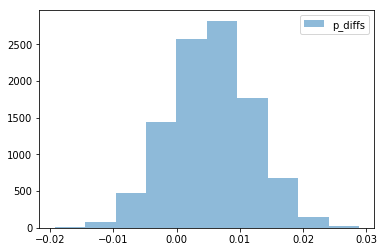

In [29]:
#plotted histogram of p_diffs
plt.hist(p_diffs, alpha = 0.5, label='p_diffs');
plt.legend();

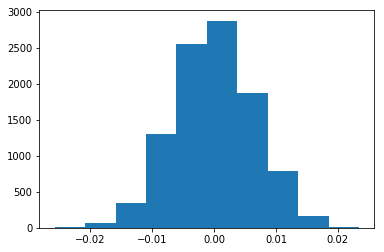

In [30]:
#sampling distribution of p_diffs under the null
null_vals = np.random.normal(pnew_pold, p_diffs_std, 10000)
plt.hist(null_vals);

**Histograms of above show sample mean of p_diffs and the second is the sampling distribution under the null assuming there is truly no difference.  Both show a normal distribution under the central limit theorem**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
#actual difference
obs_diff = control_mean - treatment_mean

#prop of p_diffs greater than actual difference
prob_stat1 = (null_vals > obs_diff).mean()
prob_stat2 = (0 < null_vals).mean()

print('proportion of p_diffs greater than actual difference:',prob_stat1 + prob_stat2)

proportion of p_diffs greater than actual difference: 0.906


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The proportion computed seems to be the p_value; stated earlier our Type I error rate is 5%.  The calculated p-value is higher than the 5% threshold; therefore, we would fail to reject the null hypothesis, that is stay with the null hypothesis. There is not sufficient evidence to convert to the new page.**
$$H_0: {P-Value} > 5\% $$
$$H_1: {P-Value} \leq 5\% $$

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
df2.groupby(['landing_page', 'converted']).count()

user_id  timestamp   group
landing_page converted                            
new_page     0           128046     128046  128046
             1            17264      17264   17264
old_page     0           127785     127785  127785
             1            17489      17489   17489

In [33]:
import statsmodels.api as sm

convert_old = 17489
convert_new = 17264
n_old = 145274
n_new = 145310

C:\Users\rprea\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
#calculated z-score and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative='larger')
print('z-score:',z_score)
print('p-value:',p_value)

z-score: -1.3109241984234394
p-value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score tells you how many standard errors there are between sample mean and population mean.  The z-score calculation .-1.31 std deviations under the mean. Also, would indicate the data is normally distributed.  The p-value is greater than 5% threshold indicating we would fail to reject the null hypothesis, that is stay with the null hypothesis. The built in function seems to agree; there is not sufficient evidence to convert to the new page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression, because we're trying to predict two possible outcomes. **

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#create dummy variables
df2[['treatment','control']]= pd.get_dummies(df2['group'])

#dropped the treatment column
df2.drop('treatment',axis=1,inplace = True)

#renamed control column
df2.rename(columns={'control':'ab_page'},inplace = True)

#intercept column
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
#logistic regression model fitted with using the intercept and ab_page column
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-08-03 00:59 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**p-value associated with the ab_page is .1899 and drastically lower. Due to the fact it's a two tailed test concerned with whether it had any affect at all, basically new page doesn't equal old page.  Where earlier it was one tailed test; page with the higer conversion rate. The evidence is still weak against the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**based on the current data I don't see advantages in adding additional items in my regression model.  I think factors such as users that are happy or unhappy with old_page would be helpful and users that don't have preference.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
### Create the necessary dummy variables
country_variables = pd.get_dummies(df_new['country'])
df2_new = df_new.join(country_variables)
df2_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
### Fit Your Linear Model And Obtain the Results
logit_mod2 = sm.Logit(df2_new['converted'], df2_new[['intercept', 'ab_page','CA','US']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-08-03 01:00 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

In [42]:
np.exp(results2.params)

intercept    0.138154
ab_page      0.985168
CA           0.950621
US           0.990165
dtype: float64

In [43]:
1/np.exp(results2.params)

intercept    7.238314
ab_page      1.015056
CA           1.051944
US           1.009932
dtype: float64

In [44]:
df2_new.groupby('country').mean()['converted']

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

**p-values in relation to conversion are not significantly significant, since our type I error rate is 5%.  Looking at the numbers.  Using UK as the baseline, Users in UK are 1.05 times more likely on convert than CA and 1.00 times than US users.**

<a id='conclusions'></a>
## Conclusions

In conclusion, the population data probabilities of converting to the new_page is slightly higher it might make one choose the alternative hypothesis, but looking closer the difference is extremely small and more information is needed to make a better decision.  A/B test data proved otherwise; we sampled our distribution of difference in means compareed to the null distribution both were normal.  The p-value for A/B test was well over the 5% type I error rate threshold for the sample.  When compared to the converted new_users/old_users it showed similar value as well as it being over the 5% threshold. In addition, the logistics regressions showed the countries and ab_page showed no significant statistical analysis in relation to conversion, but you could see which country converted at high rates in relation to other etc.

In closing, we would fail to reject the null hypothesis, that is stay with the null hypothesis. We couldn't find sufficient evidence to convert to the new page.